In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Reshape, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling2D, UpSampling1D 
from keras.layers import LocallyConnected1D, LocallyConnected2D, LSTM, RepeatVector
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot

In [4]:
n = 2
dim4 = True
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 2)


In [5]:
n = 1000
min_f = -4 # normalized to 0
max_f = 4
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=1,
    n_channels=3,
    d_phase=True,
    return_params=True,
    dim4=dim4,
    multiTrack=multiTrack)

 [INFO] : 
 |  reduced dims:
 |  (1000, 100, 3)


In [6]:
x_train.shape

(1000, 100, 3, 1)

In [7]:
m = int(x_train.shape[0] * 0.9)
[x_train.shape, m]

[(1000, 100, 3, 1), 900]

In [8]:
x_test = x_train[m:]
x_train = x_train[:m]

m (50, 3)


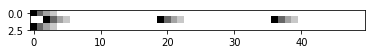

m (50, 3)


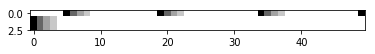

m (50, 3)


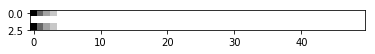

In [9]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
plot.single(x_train[2, :50,:,0])

In [10]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(100, 3, 1)

In [11]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [98]:
def encoder(input_size, dropout=0.1, p='same'):
    encoder_input = Input(shape=input_size)
    
    # Convolve & Pool
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding=p)(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    h = Conv1D(128, kernel_size=2, strides=2, activation='relu', padding=p)(h)
    h = Conv1D(128, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    #     x = AveragePooling2D((2, 2))(x)
#     h = Conv1D(128, kernel_size=2, strides=2, activation='relu', padding='same')(h)

    # Dense layers
    h = Dropout(dropout)(h) # uncomment when using larger batches
    h = Flatten()(h)
    h = Dense(intermediate_dim, activation='relu')(h)
    # h = Dense(intermediate_dim, activation='relu', kernel_regularizer=k_reg, activity_regularizer=a_reg)(h)
    
#     x = Reshape((-1, 1, 1))(x)

    h = Reshape((-1, intermediate_dim))(h)
    n_capsules = 10
    capsule_dim = 10
    n_routings = 3
    share_weights = True
    h = Capsule(n_capsules, capsule_dim, n_routings, share_weights)(h)

    # h = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(h)
    h = Reshape((n_capsules * capsule_dim,))(h)
    
    # Z Mean, Variance - no activation? TODO
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'

    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [99]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

shared weights, shape = (1, 128, 100) 12800
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 100, 3, 1)    0                                            
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 100, 3)       0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 50, 32)       224         reshape_13[0][0]                 
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 50, 64)       4160        conv1d_13[0][0]                  
_________________________________________________________________

In [100]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [101]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)

In [102]:
def list_decoders(output_shape, p='valid'):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape
    m = 4 # multiplier for dims
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    output_shape = (timesteps, notes, channels)
    
    # we instantiate these layers separately so as to reuse them later
    decoders = []
    decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(intermediate_dim * 2, activation='relu') ]
    decoders += [ Dense(np.prod(output_shape), activation='relu') ]
#     decoders += [ Reshape(output_shape[-3:]) ]
    
    # Convolution
    # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    timesteps_ = int(timesteps / 2)
    
#     decoders += [ Conv2DTranspose(timesteps_, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     decoders += [ Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p) ]
#    # decoder += [Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=(3,1), activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=3, activation='relu', padding=p)]
    
    # 'end' of upsampling
#     decoders += [ Conv2D(1, kernel_size=(1,2), strides=1, activation='relu', padding=p) ]
    # shape = ()
    # decoder_reshape2 = Reshape(dims[0:2])
    # #     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    # decoder_conv2 = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)
    
    
    # Mean (output)
    # h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    output_shape = (timesteps, notes, channels)
    
#     decoders += [ Flatten()]
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [103]:
decoders = list_decoders(input_shape)

In [104]:
decoded = utils.composition(decoders, z_output, verbose=False)

In [105]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 100, 3, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 476724      input_6[0][0]                    
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 128)          384         lambda_5[0][0]                   
__________

In [106]:
# Compute VAE loss
def vae_loss(beta=1.):
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=1)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Output "reshape_16" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_16" during training.
  # This is added back by InteractiveShellApp.init_path()


In [107]:
# train the VAE on MNIST digits
# (x_train, _), (x_test, y_test) = mnist.load_data()

In [108]:
x_train.shape

(900, 100, 3, 1)

In [109]:
print('x_train.shape:', x_train.shape)

x_train.shape: (900, 100, 3, 1)


In [110]:
batch_size = 100
epochs = 100
params = {'batch_size': batch_size, 'return_y': False}

In [111]:
phase_mod = 0.01
whitening = False

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by dataset std
#         samplewise_std_normalization=False,  # divide each input by its std
# #         zca_epsilon=10,
#         zca_whitening=whitening,
#         rotation_range=0,  # randomly rotate images in 0 to 180 degrees
#         width_shift_range=0.,  # note-channel mod, but not shuffled
#         height_shift_range=phase_mod,  # start_t, phase
#         horizontal_flip=False,  # reverse
#         vertical_flip=False)

# # datagen.fit(x_train)

In [112]:
m = 10
useDataGenerator = False
useDataGenerator = True

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>>>>\n' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x_train[:m], x_train[:m], batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x = x_batch
#             x = datagen.shuffle_3rd_dim(x_batch)
            h = vae.fit(x, verbose=1)
            for k,v in h.history.items(): 
                history[k].append(v)
            if batch_i >= n_batches:
                break
#     history = vae.fit_generator(
#         X, epochs=epochs, steps_per_epoch=X.__len__(),
#         use_multiprocessing=True, workers=2,
#         validation_data=(x_test, None))
else:
    h = vae.fit(x_train[:m], epochs=epochs, validation_data=(x_test, None))
    history = h.history

batch_size = 100

[Epoch 0/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 9s 877ms/step - loss: 208.2351
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 202.8351
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 193.1673
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 154.4050
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 125.8284
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 91.4572
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 78.7053
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 84.6218
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 74.2895
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 68.5983

[Epoch 1/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1

 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 53.4593
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 54.0994

[Epoch 9/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 52.2876
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 56.9952
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 55.2143
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 52.2873
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 51.4916
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 51.0297
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 53.1126
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 52.0163
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/st

10/10 [==============================] - 0s 2ms/step - loss: 49.3484
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 51.1038
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 48.6726
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 51.3281

[Epoch 18/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 52.1634
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 50.5084
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 50.6138
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 49.6628
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 50.7895
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 50.8752
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 51.0484
 

 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 49.8659
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 49.9620
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 51.3615
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 49.8691
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 51.2047

[Epoch 27/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 51.0337
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 48.7797
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 51.9949
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 49.8601
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 50.9355
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/s

10/10 [==============================] - 0s 2ms/step - loss: 48.1103
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 48.3948
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 45.5421
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 47.3782
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 48.6081
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 50.4519
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 49.3254

[Epoch 36/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 46.6264
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 48.4038
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 48.4973
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 47.2335
 

 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 46.3850
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 45.1955
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 44.8017
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 44.9010
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 48.1518
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 46.4817
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 48.6194
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 46.0488

[Epoch 45/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 48.3063
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 48.8941
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/s

10/10 [==============================] - 0s 3ms/step - loss: 45.4514
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 44.8007
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 45.3735
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 46.0397
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 46.2562
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 42.7371
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 46.5792
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 45.1201
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 44.4991
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 46.1978

[Epoch 54/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 8ms/step - loss: 45.4659
 

 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 45.7645

[Epoch 62/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 46.0057
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 45.5456
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 45.2926
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 44.4326
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 45.9659
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 45.2974
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 45.6862
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 44.4519
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 45.8888
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 4ms/s

10/10 [==============================] - 0s 4ms/step - loss: 42.4215
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 41.9164
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 43.5887

[Epoch 71/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 42.8548
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 43.2917
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 41.6026
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 44.1853
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 45.2620
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 45.2429
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 45.7572
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 43.5978
 

 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 52.7334
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 43.5144
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 41.6010
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 44.4244

[Epoch 80/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 46.2196
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 43.6791
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 44.4680
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 42.9036
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 43.9555
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 51.5062
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/s

10/10 [==============================] - 0s 2ms/step - loss: 40.5705
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 41.2359
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 44.2852
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 44.4501
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 44.0498
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 41.8750

[Epoch 89/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 46.3020
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 47.4635
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 44.7228
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 41.8640
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 41.6839
 

 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 41.5920
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 46.1572
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 42.3114
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 42.3360
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 44.1450
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 43.6251
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 41.9288

[Epoch 98/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 43.9272
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 45.5452
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 42.4253
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 2ms/s

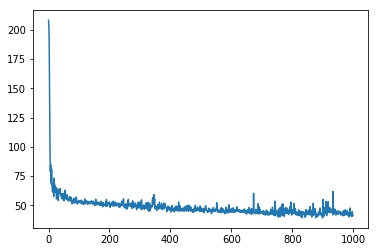

In [113]:
# x = epochs * batches
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [114]:
# datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
# x = datagen.standardize(x_train[:10])
# i = 0
# plot.single(x_train[i, :50, :, 0])
# plot.single(x[i, :50, :, 0])

m (50, 3)


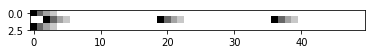

m (50, 3)


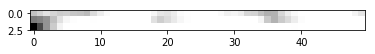

m (50, 3)


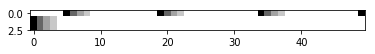

m (50, 3)


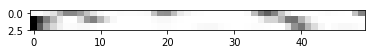

In [115]:
i = 0
j = 1
x = vae.predict(x_train[:10])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])
plot.single(x_train[j, :50, :, 0])
plot.single(x[j, :50, :, 0])

In [116]:
x.shape

(10, 100, 3, 1)

m (30, 3)


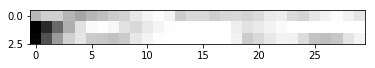

In [117]:
# interpolate - mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

m (30, 3)


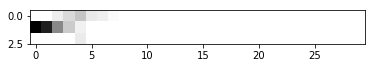

In [118]:
# interpolate - min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

In [119]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [120]:
x_test.shape

(100, 100, 3, 1)

In [121]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 2)

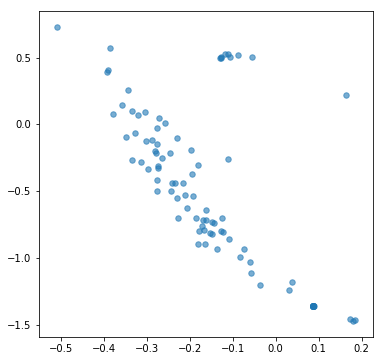

In [122]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.6, s=30) # c=y_test

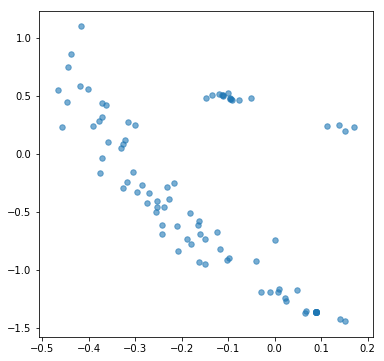

In [123]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.6, s=30)
# plt.colorbar()

In [124]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [125]:
def latent(generator,
           batch_size=2,
           latent_dim=2,
           x_encoded=0.,
           latent_indices=(0, 1),
           n=10,
           m=4,
           crop_size=30,
           margin_top=1,
           margin_left=1,
           min_x=0.05,
           max_x=0.95,
           min_y=0.05,
           max_y=0.95):
    """ Original: keras.keras.examples.variational_autoencoder
    :x_encoded :: float | [ float ]
    
    to swap x,y set `latent_indices`` to (1,0)
    """
    if not isinstance(x_encoded, np.ndarray):
        x_encoded = np.repeat(x_encoded, latent_dim)
    x_decoded = generator.predict(x_encoded.reshape([1, latent_dim]))

    # display a 2D manifold of output samples
    size1 = x_decoded.shape[2]
    size2 = crop_size  # crop x_train.shape[1]
    margin_y, margin_x = n * margin_top * 3, m * margin_left * 3
    figure = np.zeros((size1 * n + margin_y, size2 * m + margin_x))
    # linearly spaced coordinates on the unit square were transformed through
    # the inverse CDF (ppf) of the Gaussian to produce values of the latent
    # variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(min_x, max_x, n))
    grid_y = norm.ppf(np.linspace(min_y, max_y, m))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = x_encoded.copy()
            z_sample[np.array(latent_indices)] = (xi, yi)
            # z_sample = np.array([[yi, xi]])
            # TODO check whether batch_size influences the generator output
            z_sample = np.tile(z_sample, batch_size).reshape(
                batch_size, latent_dim)
            x_decoded = generator.predict(z_sample, batch_size=batch_size)
            sample = x_decoded[0, :size2].reshape((size2, size1)).transpose()
            sample.reshape(size1, size2)
            # coordinates of the current sample
            a = i * size1 + i * margin_top * 3
            b = (i + 1) * size1 + i * margin_top * 3
            c = j * size2 + j * margin_left * 3
            d = (j + 1) * size2 + j * margin_left * 3
            # table separators (partially overlapping)
            figure[a, :] = 0
            figure[a + 1, 1:-1] = 0.3
            figure[a + 2, :] = 0
            figure[:, c] = 0
            figure[1:, c + 1] = 0.3
            figure[:, c + 2] = 0
            a, b, c, d = a + 3, b + 3, c + 3, d + 3
            figure[a:b, c:d] = sample

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray_r')
    plt.show()

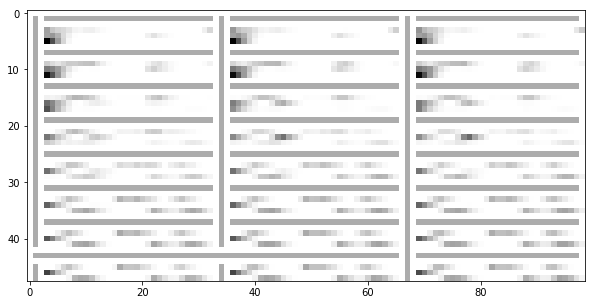

In [126]:
min_y = 0.01
max_y = 0.5
latent(generator, batch_size,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

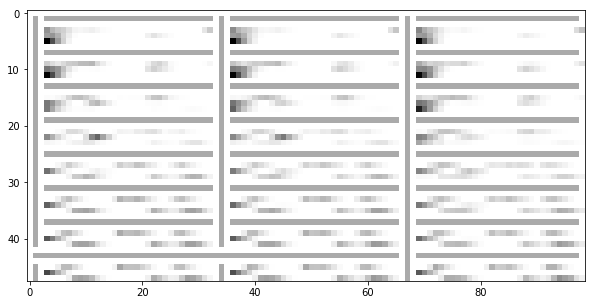

In [127]:
min_y2 = max_y
latent(generator, batch_size,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)